### PhenoScore 


<!-- #### $$
    \text{delta} \rightarrow
    f(x,y) = \log \left( \frac
        {\sum \limits _{i=1} ^{R} N_{y}^{i}}
        {\sum \limits _{i=1} ^{R} N_{x}^{i}}
    \right) 
$$
 -->

<!-- #### $$
    \text{phenotype score} \rightarrow
    f(x,y, x_{ctrl},y_{ctrl}) = \text{delta}(x,y) - ) 
    \times \frac{ 1 }{d_{growth}}
$$ -->



Log ratio of $y$ vs $x$:
#### $$
    \Delta = \log(\frac
    {\begin{bmatrix}{N_{y}}\end{bmatrix}_{(a,b)} + 1}
    {\begin{bmatrix}{N_{x}}\end{bmatrix}_{(a,b)} + 1}
    )
$$

- $y \rightarrow$ condition $x$ (e.g. treated samples)
- $x \rightarrow$ condition $y$ (e.g. $t_{0}$ samples)
- $a \rightarrow$ number of oligo constructs with sgRNAs targeting $T$
- $b \rightarrow$ number of biological replicates, $R$ (e.g. 2 or 3)
- $N_{x}$ | $N_{y} \rightarrow$ read counts normalized for sequencing depth in condition $x$ or $y$

<!-- - $N_{x}^{i}$ | $N_{y}^{i} \rightarrow$ NGS read counts for replicate $i$ in condition $x$ or $y$ -->
<!-- - $R \rightarrow$ number of biological replicates (e.g. 2 or 3) -->

___
Here is a formula for V3 library with single oligo construct per gene (i.e. 2 sgRNA in one oligo targeting same gene).

Phenotype score for each $T$ comparing $y$ vs $x$:
#### $$
    \text{PhenoScore}(T,x,y) =
    \left( 
    \overline{\Delta_{(x,y)}} - \text{median}({\overline{\Delta_{(x_{ctrl},y_{ctrl})}}})
    \right)
    \times \frac{ 1 }{d_{growth}}
    \times \frac{ 1 }{\sigma_{ctrl}}
$$

- $\overline{\Delta(x,y)} \rightarrow$ log ratio averaged across replicates
- $T \rightarrow$ oligo constructs with sgRNAs targeting $T$

#### $$
    \text{p-value} \rightarrow f(T,x,y) = \text{t-test} \left(
    \begin{bmatrix}{N_{x}}\end{bmatrix}_{(a,b)},
    \begin{bmatrix}{N_{y}}\end{bmatrix}_{(a,b)}
\right)
$$

- [Dependent_t-test_for_paired_samples](https://en.wikipedia.org/wiki/Student%27s_t-test#Dependent_t-test_for_paired_samples) using [`scipy.stats.ttest_rel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)
> This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
___

In [1]:
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import scipy

### phenoScore

In [3]:
from scripts.phenoScore import ann_score_df,runPhenoScore,run_deseq2_norm

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
source('scripts/plots.R')
library(tidyverse)
# library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [6]:
THRESHOLD = 2

In [7]:
screengrowthsummary = pd.read_excel('PRDX1ko_screengrowthsummary.xlsx')

    So most conditions had 7-8 doublings but KO+DNAPKi only a little over 2

    day 11 is the last day of the screen

https://github.com/connorferster/handcalcs

In [8]:
# import handcalcs.render
# from handcalcs import handcalc

In [9]:
# screengrowthsummary

### Data loading
> Note that we are also explaining this step in the ‘getting started’ example. To perform differential expression analysis (DEA), PyDESeq2 requires two types of inputs:

> A count matrix of shape ‘number of samples’ x ‘number of genes’, containing read counts (non-negative integers),

> Clinical data (or “column” data) of shape ‘number of samples’ x ‘number of variables’, containing sample annotations that will be used to split the data in cohorts.

In [12]:
adata = ad.read_h5ad('results/adata_counts.h5ad.gz')
adata.obs['condition'] = adata.obs.treatment.replace('-','T0')
adata.obs = adata.obs[['cell line','condition','rep']]
adata.obs.index.name = None

In [13]:
adata

AnnData object with n_obs × n_vars = 16 × 21097
    obs: 'cell line', 'condition', 'rep'
    var: 'target', 'targetType'
    layers: 'log2(x+1)', 'raw'

In [14]:
target_df = adata.var.sort_values(by=['target','targetType'],ascending=True)[['target']]

#### DESeq2 count normalization

add `deseq2` norm

In [15]:
run_deseq2_norm(adata)

### sanity checks

In [16]:
adata

AnnData object with n_obs × n_vars = 16 × 21097
    obs: 'cell line', 'condition', 'rep', 'size_factors'
    var: 'target', 'targetType'
    layers: 'log2(x+1)', 'raw', 'deseq'

In [17]:
pd.concat(
    {'raw':adata[:,adata.var.target.eq('ATR')].to_df(layer='raw'),
     'log2(x+1)':adata[:,adata.var.target.eq('ATR')].to_df(layer='log2(x+1)'),
    'deseq2':adata[:,adata.var.target.eq('ATR')].to_df(layer='deseq'),
    },axis=1).T

,,i01,i02,i03,i04,i05,i06,i07,i08,i09,i10,i11,i12,i13,i14,i15,i16
raw,ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2++ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2,2070.000000,1869.000000,22.000000,85.000000,37.000000,31.000000,62.000000,10.000000,2124.000000,1920.000000,37.000000,33.000000,36.000000,166.000000,166.000000,198.000000
log2(x+1),ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2++ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2,11.016112,10.868823,4.523562,6.426265,5.247928,5.000000,5.977280,3.459432,11.053247,10.907642,5.247928,5.087463,5.209453,7.383704,7.383704,7.636625
deseq2,ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2++ATR_-_142297649.23-P1P2|ATR_+_142297571.23-P1P2,3226.957358,2431.169013,16.744589,71.876477,29.049171,30.504072,54.262816,11.615738,2842.545055,2768.869474,33.886736,29.723633,14.754151,197.712716,191.448697,199.386809


In [18]:
# adata.write_h5ad('results/adata_counts_.h5ad.gz',compression='gzip')

# Statistical analysis 

In [19]:
results = {}

## PRDX1_parent

In [20]:
adata_parent = adata[adata.obs['cell line'].eq('parent')].copy()

In [21]:
adata_parent.obs

,cell line,condition,rep,size_factors
i01,parent,T0,1,0.641471
i02,parent,T0,2,0.768766
i03,parent,vehicle,1,1.313857
i04,parent,vehicle,2,1.182584
i05,parent,vehicle,3,1.273702
i06,parent,DNAPKi,1,1.016258
i07,parent,DNAPKi,2,1.142587
i08,parent,DNAPKi,3,0.860901


### gamma 

In [22]:
score = 'gamma'
cond1 = "T0"
cond2 = "vehicle"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [23]:
runPhenoScore(
    adata_parent,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0]
)

#### Save to results

In [24]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3720
resistance_hit        76
gene_non_hit       16275
non-targeting       1026
dtype: int64

#### volcano plots

In [25]:
df = results[screen_name].reset_index().copy()

In [26]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.867277610454432, 1.3923369823352967, 5.153281987091899)

In [27]:
%%R
source('scripts/plots.R')

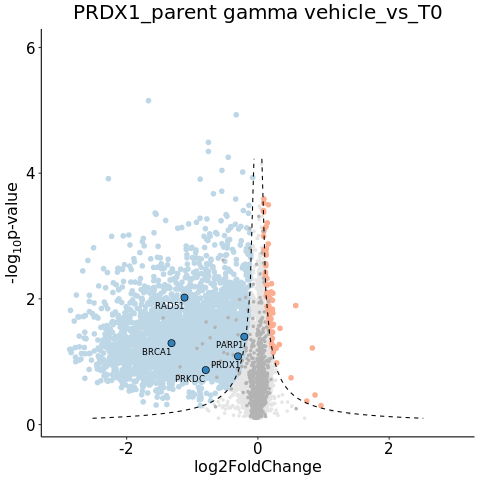

In [28]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### tau

In [29]:
score = 'tau'
cond1 = "T0"
cond2 = "DNAPKi"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [30]:
runPhenoScore(
    adata_parent,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]
)

#### Save to results

In [31]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3704
resistance_hit        70
gene_non_hit       16297
non-targeting       1026
dtype: int64

#### volcano plots

In [32]:
df = results[screen_name].reset_index().copy()

In [33]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.92001204964309, 1.6245284537858926, 4.678425046287424)

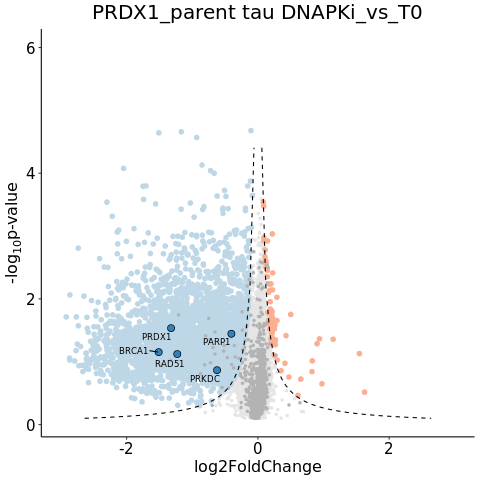

In [34]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### rho

In [35]:
score = 'rho'
cond1 = "vehicle"
cond2 = "DNAPKi"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [36]:
runPhenoScore(
    adata_parent,cond1,cond2,n_reps=3,
    growth_rate=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]
    ])
)

#### Save to results

In [41]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      874
resistance_hit       943
gene_non_hit       18254
non-targeting       1026
dtype: int64

#### volcano plots

In [42]:
df = results[screen_name].reset_index().copy()

In [43]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.7335990484022497, 2.872885617787636, 5.354735824724727)

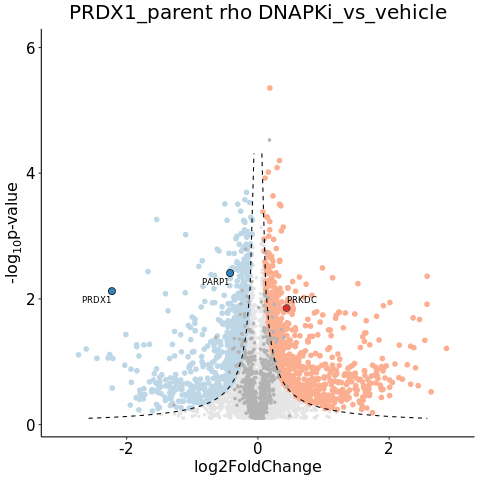

In [44]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRKDC"
    ))) -> p

p %>% label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRDX1", 
        # "RAD51", 
        "PARP1"
        # "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## PRDX1_KO

In [47]:
adata_KO = adata[adata.obs['cell line'].eq('PRDX1KO')].copy()

In [48]:
adata_KO.obs

,cell line,condition,rep,size_factors
i09,PRDX1KO,T0,1,0.747218
i10,PRDX1KO,T0,2,0.693424
i11,PRDX1KO,vehicle,1,1.091873
i12,PRDX1KO,vehicle,2,1.110228
i13,PRDX1KO,vehicle,3,2.439991
i14,PRDX1KO,DNAPKi,1,0.839602
i15,PRDX1KO,DNAPKi,2,0.867073
i16,PRDX1KO,DNAPKi,3,0.993045


### gamma

In [49]:
score = 'gamma'
cond1 = "T0"
cond2 = "vehicle"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [50]:
runPhenoScore(
    adata_KO,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
)

#### Save to results

In [51]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3255
resistance_hit       122
gene_non_hit       16694
non-targeting       1026
dtype: int64

#### volcano plots

In [52]:
df = results[screen_name].reset_index().copy()

In [53]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-3.5926818888707266, 1.4796094855546478, 4.970620837389516)

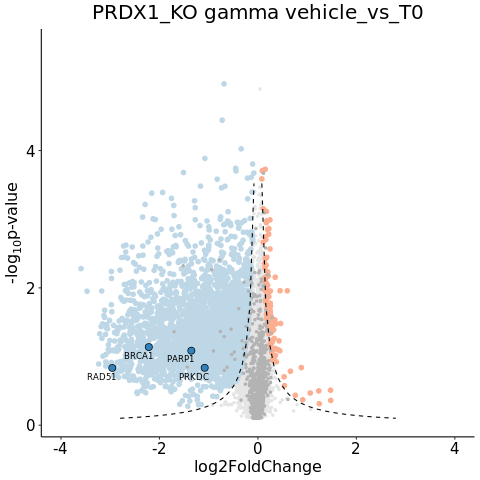

In [54]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-4,xlim_r=4, ylim=5.5,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### tau

In [55]:
score = 'tau'
cond1 = "T0"
cond2 = "DNAPKi"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [56]:
runPhenoScore(
    adata_KO,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_DNAPKi'].values[0]
)

#### Save to results

In [57]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     2642
resistance_hit       278
gene_non_hit       17151
non-targeting       1026
dtype: int64

#### volcano plots

In [58]:
df = results[screen_name].reset_index().copy()

In [59]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-13.623205446006606, 7.842597561995435, 5.28705668935465)

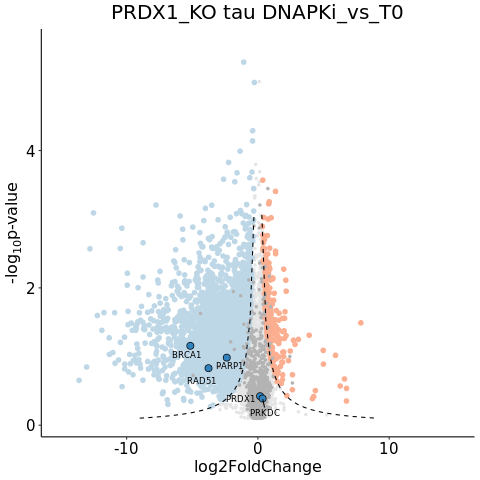

In [60]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-15,xlim_r=15, ylim=5.5,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### rho

In [61]:
score = 'rho'
cond1 = "vehicle"
cond2 = "DNAPKi"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [62]:
runPhenoScore(
    adata_KO,cond1,cond2,n_reps=3,
    growth_rate=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_DNAPKi'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
    ])   
)

#### Save to results

In [63]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      271
resistance_hit      3051
gene_non_hit       16749
non-targeting       1026
dtype: int64

#### volcano plots

In [64]:
df = results[screen_name].reset_index().copy()

In [65]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.122151549680133, 4.740173687303975, 5.17247283805695)

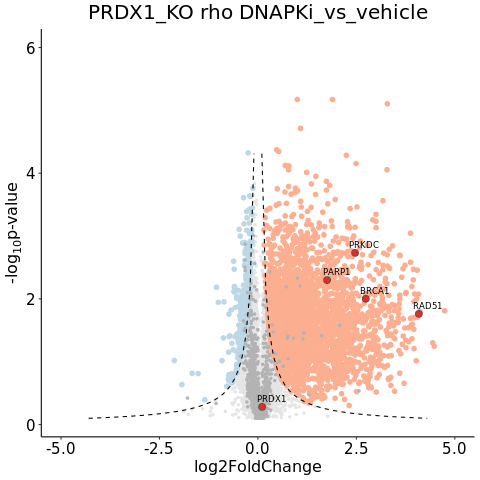

In [66]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-5,xlim_r=5, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## vehicle
    vehicle_PRDX1KO_vs_vehicle_parent

In [67]:
adata_vehicle = adata[adata.obs['condition'].eq('vehicle')].copy()

adata_vehicle.obs['condition'] = adata_vehicle.obs['cell line']

del adata_vehicle.obs['cell line']

In [68]:
adata_vehicle.obs

,condition,rep,size_factors
i03,parent,1,1.313857
i04,parent,2,1.182584
i05,parent,3,1.273702
i11,PRDX1KO,1,1.091873
i12,PRDX1KO,2,1.110228
i13,PRDX1KO,3,2.439991


### rho

In [69]:
score = 'rho'
cond1 = "parent"
cond2 = "PRDX1KO"

screen_name = f'vehicle {score} {cond2}_vs_{cond1}'

In [70]:
runPhenoScore(
    adata_vehicle,cond1,cond2,n_reps=3,
    growth_rate=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
    ])   

)

#### Save to results

In [71]:
results[screen_name] = ann_score_df(
    adata_vehicle.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      841
resistance_hit      2704
gene_non_hit       16526
non-targeting       1026
dtype: int64

#### volcano plots

In [72]:
df = results[screen_name].reset_index().copy()

In [73]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.537471314962964, 2.4744426275359284, 5.039225010601307)

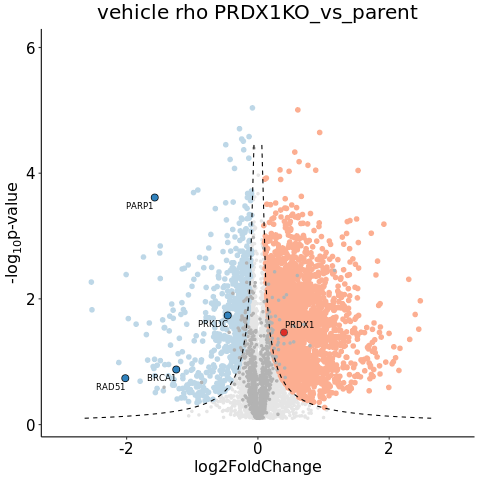

In [74]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRDX1"
    ))) -> p

p %>% label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## Save results as a excel

In [75]:
data = pd.concat(results,axis=1)

In [76]:
set(data.columns.to_frame()[0].to_list())

{'PRDX1_KO gamma vehicle_vs_T0',
 'PRDX1_KO rho DNAPKi_vs_vehicle',
 'PRDX1_KO tau DNAPKi_vs_T0',
 'PRDX1_parent gamma vehicle_vs_T0',
 'PRDX1_parent rho DNAPKi_vs_vehicle',
 'PRDX1_parent tau DNAPKi_vs_T0',
 'vehicle rho PRDX1KO_vs_parent'}

In [ ]:
data.to_excel('results/phenotype_scores.xlsx')

# 

In [ ]:
%load_ext watermark

In [ ]:
%watermark

In [ ]:
%watermark --iversions